# Uncertainty and sensitivity

TEA/LCA is a powerful tool to understand the potential sustainability of a technology. But it can be extremely difficult to navigate uncertainties in design decisions (e.g., refinery size and location), market variability, and technological performance. Evaluating just one representative scenario (under a single set of assumptions) gives an incomplete picture that is not conclusive. This is especially true for conceptual and early-stage technologies, which have higher levels of uncertainty. We need to pair TEA/LCA with rigorous uncertainty/sensitivity analyses to explore the landscape of potential outcomes, identify representative scenarios (through sensitivity analysis), and establish technological performance targets. To learn more about expediting RD&D through modeling, we recommend reading on [quantitive sustainable design (QSD) methodology](https://pubs.rsc.org/en/content/articlelanding/2022/ew/d2ew00431c).

As one of its central features, BioSTEAM streamlines TEA/LCA with rigorous uncertainty/sensitivity analyses to empower researchers with the ability to navigate uncertainty and guide RD&D. Using NREL's model for cellulosic ethanol production from cornstover as a case study, this tutorial will demonstrate how to construct a model and perform Monte Carlo-based uncertainty/sensitivity analyses to establish potential targets for improvement. 

## Framework

BioSTEAM streamlines uncertainty analysis with an object-oriented framework where a [Model](../API/evaluation/Model.txt) object samples from parameter distributions and evaluates sustainability indicators at each new condition. In essence, a Model object sets parameter values, simulates the biorefinery system, and evaluates indicators across an array of samples.

On the backend, Model objects cut down simulation time using a number of strategies, including sorting the samples to minimize perturbations to the system between simulation. 


### Distributions

**Let's first learn how to create common parameter distributions using** [chaospy](https://chaospy.readthedocs.io/en/master/user_guide/quick_tutorial.html).

A triangular distribution is typically used when the input parameter is uncertain within given limits, but is heuristically known to take a particular value. Create a triangular distribution:

In [1]:
from warnings import filterwarnings; filterwarnings('ignore') 
from chaospy import distributions as shape
lower_bound = 0
most_probable = 0.5
upper_bound = 1
triang = shape.Triangle(lower_bound, most_probable, upper_bound)
print(triang)

Triangle(0, 0.5, 1)


A uniform distribution is used when the theoretical limits of the parameter is known, but no information is available to discern which values are more probable. Create a uniform distribution:

In [2]:
from chaospy import distributions as shape
lower_bound = 0
upper_bound = 1
unif = shape.Uniform(lower_bound, upper_bound)
print(unif)

Uniform()


A large set of distributions are available through chaospy, but generally triangular and uniform distributions are the most widely used to describe the uncertainty of parameters in Monte Carlo analyses.

### Parameters and indicators

**Parameter and Indicator objects are simply structures BioSTEAM uses to manage setting input parameters and evaluating indicator results.**

Parameter objects use a `setter` function to set the parameter value related to an `element` (e.g. unit operation, stream, etc.).  They can have a `distribution` (e.g., triangular, uniform) attribute for Model objects to sample from. Parameters also have `name`, `units` of measure, and `baseline` value attributes for bookkeeping purposes. BioSTEAM incorporates the `element`, `name`, and `units` of measure when creating a DataFrame of Monte Carlo results and parameter distributions. Similarly, an Indicator object uses a `getter` function for to evaluate the indicator value and has `name`, `element`, and `units` of measure attributes for bookkeeping.

Hopefully things will be become clearer with the following examples using a cellulosic ethanol production process.

## Creating a Model object

**Model objects are used to evaluate indicators given a set of system parameters.**

Create a Model object of the cellulosic ethanol:

In [3]:
import biosteam as bst
from biorefineries import cellulosic
from biorefineries.tea import create_cellulosic_ethanol_tea
bst.nbtutorial()
chemicals = cellulosic.create_cellulosic_ethanol_chemicals()
bst.settings.set_thermo(chemicals)
cellulosic.load_process_settings()
bst.F.set_flowsheet('cellulosic_ethanol') # F is the main flowsheet
system = cellulosic.create_cellulosic_ethanol_system()
tea = create_cellulosic_ethanol_tea(system)
model = bst.Model(system)

The Model object begins with no parameters and no indicators: 

In [4]:
model

Model:
parameters: None
indicators: None


### Add indicators

In [5]:
@model.indicator(units='USD/kg')
def MESP(): return tea.solve_price(bst.F.ethanol)

@model.indicator(units='10^6 * USD')
def TCI(): return tea.TCI / 1e6 # total capital investment

model

Model:
parameters: None
indicators: MESP [USD/kg]
            TCI [10^6 * USD]


Note that the decorator uses the function to create an Indicator object and adds it to the model.

### Add parameters

In [6]:
fermentation = bst.F.R303
ethanol_rxn = fermentation.cofermentation[0]
xylose_rxn = fermentation.cofermentation[4]
@model.parameter(
    element='fermentation', units='% theoretical', # Metadata (does not affect simulation)
    bounds=(80, 95), # Lower and upper bound
    distribution='uniform', # Same as shape.Uniform(lower, upper)
    baseline=0.5 * (80 + 95), # Baseline assumption
    coupled=True, # Optional, tells BioSTEAM this impacts mass/energy balances
)
def set_glucose_to_ethanol_yield(glucose_to_ethanol_yield):
    ethanol_rxn.X = glucose_to_ethanol_yield / 100
    
@model.parameter(
    element='fermentation', units='% theoretical',
    bounds=(70, 90), # Baseline defaults to the average of the lower and upper bounds.
    distribution='uniform',
    coupled=True,
)
def set_xylose_to_ethanol_yield(xylose_to_ethanol_yield):
    xylose_rxn.X = xylose_to_ethanol_yield / 100
    
feedstock = bst.F.cornstover # The feedstock stream
lb = feedstock.price * 0.9 # Minimum price
ub = feedstock.price * 1.1 # Maximum price
@model.parameter(
    element='cornstover', units='USD/kg',
    bounds=(lb, ub),
    baseline=feedstock.price, 
    distribution='triangular' # Defaults to shape.Triangular(lower=lb, midpoint=baseline, upper=ub)
)
def set_feed_price(feedstock_price):
    feedstock.price = feedstock_price
    
processing_capacity = feedstock.F_mass * tea.operating_hours / 1e3 # Annual processing capacity MT / y
lb = processing_capacity * 0.9
ub = processing_capacity * 1.1
@model.parameter(
    units='MT/yr',
    bounds=(lb, ub),
    element='Biorefinery',
    baseline=processing_capacity,
    distribution='triangular',
    coupled=True,
)
def set_processing_capacity(processing_capacity):
    feedstock.F_mass = 1e3 * processing_capacity / tea.operating_hours
    
model

Model:
parameters: Fermentation - Glucose to ethanol yield [% theoretical]
            Fermentation - Xylose to ethanol yield [% theoretical]
            Cornstover - Feedstock price [USD/kg]
            Biorefinery - Processing capacity [MT/yr]
indicators: MESP [USD/kg]
            TCI [10^6 * USD]


Note that the `model.parameter` decorator uses the function to create a Parameter object and adds it to the model.

### Overview of the model

Get dictionary that contain DataFrame objects of parameter distributions:

In [7]:
df_dct = model.get_distribution_summary()
df_dct['Uniform']

,Element,Name,Units,Shape,lower,upper
0,Fermentation,Glucose to ethanol yield,% theoretical,Uniform,80,95
1,Fermentation,Xylose to ethanol yield,% theoretical,Uniform,70,90


In [8]:
df_dct['Triangle']

,Element,Name,Units,Shape,lower,midpoint,upper
0,Cornstover,Feedstock price,USD/kg,Triangle,0.0464,0.0516,0.0567
1,Biorefinery,Processing capacity,MT/yr,Triangle,7.89e+05,8.77e+05,9.64e+05


Evaluate baseline scenario:

In [9]:
baseline_scenario = model.get_baseline_scenario()
baseline_scenario

Fermentation  Glucose to ethanol yield [% theoretical]       87.5
              Xylose to ethanol yield [% theoretical]          80
Cornstover    Feedstock price [USD/kg]                     0.0516
Biorefinery   Processing capacity [MT/yr]                8.77e+05
dtype: float64

In [10]:
model(baseline_scenario)

-  MESP [USD/kg]      0.711
   TCI [10^6 * USD]     378
dtype: float64

### Monte Carlo

Sample from a joint distribution, and simulate samples:

In [11]:
import numpy as np
N_samples = 1000
rule = 'L' # For Latin-Hypercube sampling
np.random.seed(1234) # For consistent results
samples = model.sample(N_samples, rule)
model.load_samples(samples, sort=True)
model.exception_hook = 'raise'
model.evaluate(
    notify=100 # Also print elapsed time after 50 simulations
) 

[100] Elapsed time: 12 sec
[200] Elapsed time: 24 sec
[300] Elapsed time: 36 sec
[400] Elapsed time: 48 sec
[500] Elapsed time: 59 sec
[600] Elapsed time: 71 sec
[700] Elapsed time: 82 sec
[800] Elapsed time: 94 sec
[900] Elapsed time: 107 sec
[1000] Elapsed time: 119 sec


All data from simulation is stored in `<Model>.table`:

In [12]:
model.table # All evaluations are stored as a pandas DataFrame

Element                             Fermentation                                                       Cornstover                 Biorefinery             -  \
Feature Glucose to ethanol yield [% theoretical] Xylose to ethanol yield [% theoretical] Feedstock price [USD/kg] Processing capacity [MT/yr] MESP [USD/kg]   
0                                      80.6                                     79.1                        0.052                    8.72e+05         0.736   
1                                      82.9                                     84.3                       0.0521                    8.74e+05          0.72   
2                                      83.5                                     74.8                       0.0538                    8.14e+05         0.756   
3                                      93.6                                     83.5                       0.0487                    8.35e+05         0.682   
4                                      81.6                                     70.8                       0.0506                    8.99e+05         0.735   
..                                      ...                                      ...                          ...                         ...           ...   
995                                    84.8                                     73.1                       0.0533                    9.44e+05          0.73   
996                                    82.3                                     86.8                       0.0495                    8.64e+05         0.707   
997                                    94.3                                     76.9                        0.051                    8.57e+05         0.697   
998                                    81.5                                     81.8                       0.0521                    8.72e+05         0.728   
999                                    86.1                                     83.6                        0.053                    8.68e+05         0.719   

Element                   
Feature TCI [10^6 * USD]  
0                    380  
1                    378  
2                    365  
3                    363  
4                    390  
..                   ...  
995                  398  
996                  375  
997                  370  
998                  379  
999                  375  

[1000 rows x 6 columns]

## Sensitivity with Spearman's rank order correlation

Model objects also presents methods for sensitivity analysis such as Spearman's correlation, a measure of monotonicity between variables:

In [13]:
df_rho, df_p = model.spearman_r()
print(df_rho['-', 'MESP [USD/kg]'])

Element       Parameter                               
Fermentation  Glucose to ethanol yield [% theoretical]   -0.637
              Xylose to ethanol yield [% theoretical]    -0.453
Cornstover    Feedstock price [USD/kg]                     0.54
Biorefinery   Processing capacity [MT/yr]                -0.258
Name: (-, MESP [USD/kg]), dtype: float64


Create a tornado plot of Spearman's correlation between all parameters and IRR:

(<Figure size 1280x960 with 3 Axes>,
 <Axes: xlabel="Spearman's correlation with MESP [USD/kg]">)

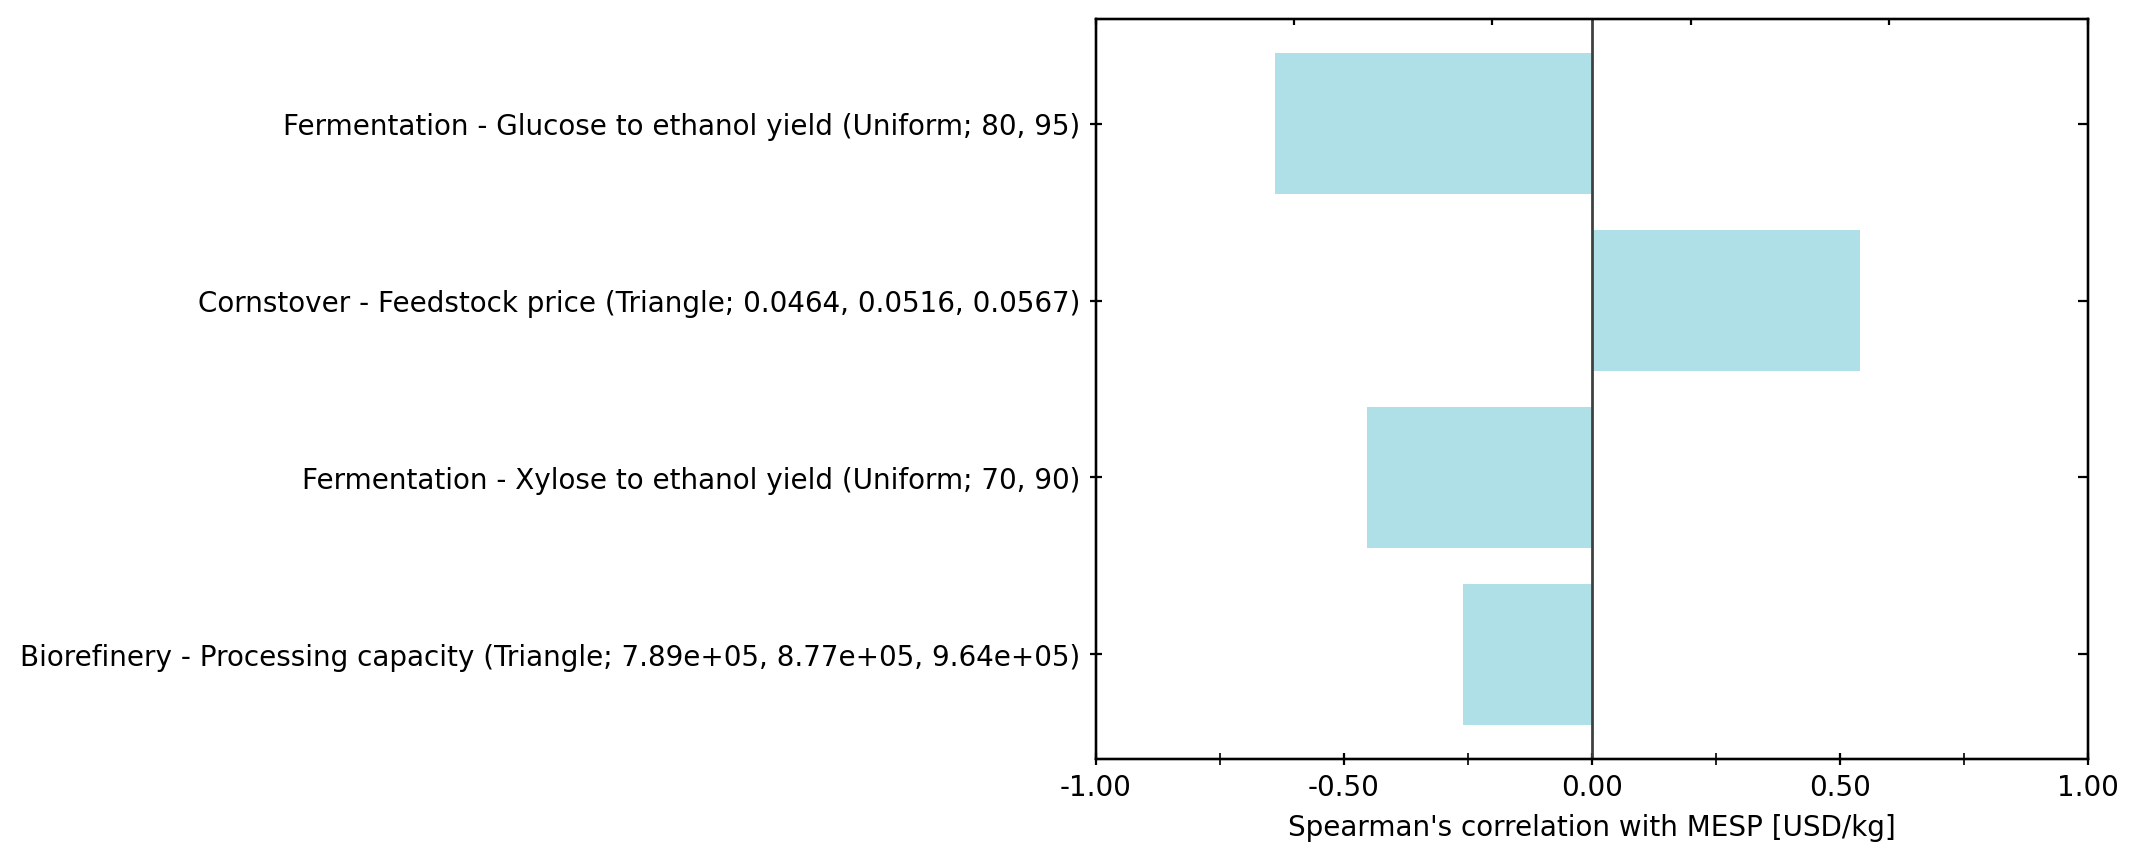

In [14]:
bst.plots.plot_spearman_1d(df_rho['-', 'MESP [USD/kg]'], 
                           index=[i.describe() for i in model.parameters],
                           name='MESP [USD/kg]')

## Single point sensitivity

A quick way to evaluate sentivity is through single point sensitivity analysis, whereby a metric is evaluated at the baseline and at the lower and upper limits of each parameter. This method ignores the interactions between parameters and their distributions, but can help screen whether a system is sensitive to a given parameter. Model objects also facilitate this analysis:

In [15]:
baseline, lower, upper = model.single_point_sensitivity()
print('BASELINE')
print('--------')
print(baseline)
print()
print('LOWER')
print('-----')
print(lower)
print()
print('UPPER')
print('-----')
print(upper)

BASELINE
--------
Element  Feature         
-        MESP [USD/kg]      0.711
         TCI [10^6 * USD]     378
dtype: float64

LOWER
-----
Element                                                      -                 
Feature                                          MESP [USD/kg] TCI [10^6 * USD]
Element      Feature                                                           
Fermentation Glucose to ethanol yield [% theo...         0.733              381
             Xylose to ethanol yield [% theor...         0.727              380
Cornstover   Feedstock price [USD/kg]                    0.685              378
Biorefinery  Processing capacity [MT/yr]                 0.726              354

UPPER
-----
Element                                                      -                 
Feature                                          MESP [USD/kg] TCI [10^6 * USD]
Element      Feature                                                           
Fermentation Glucose to ethanol yield [% theo..

Create a tornado plot of the lower and upper values of the IRR:

(<Figure size 1280x960 with 3 Axes>, <Axes: xlabel='MESP [USD/kg]'>)

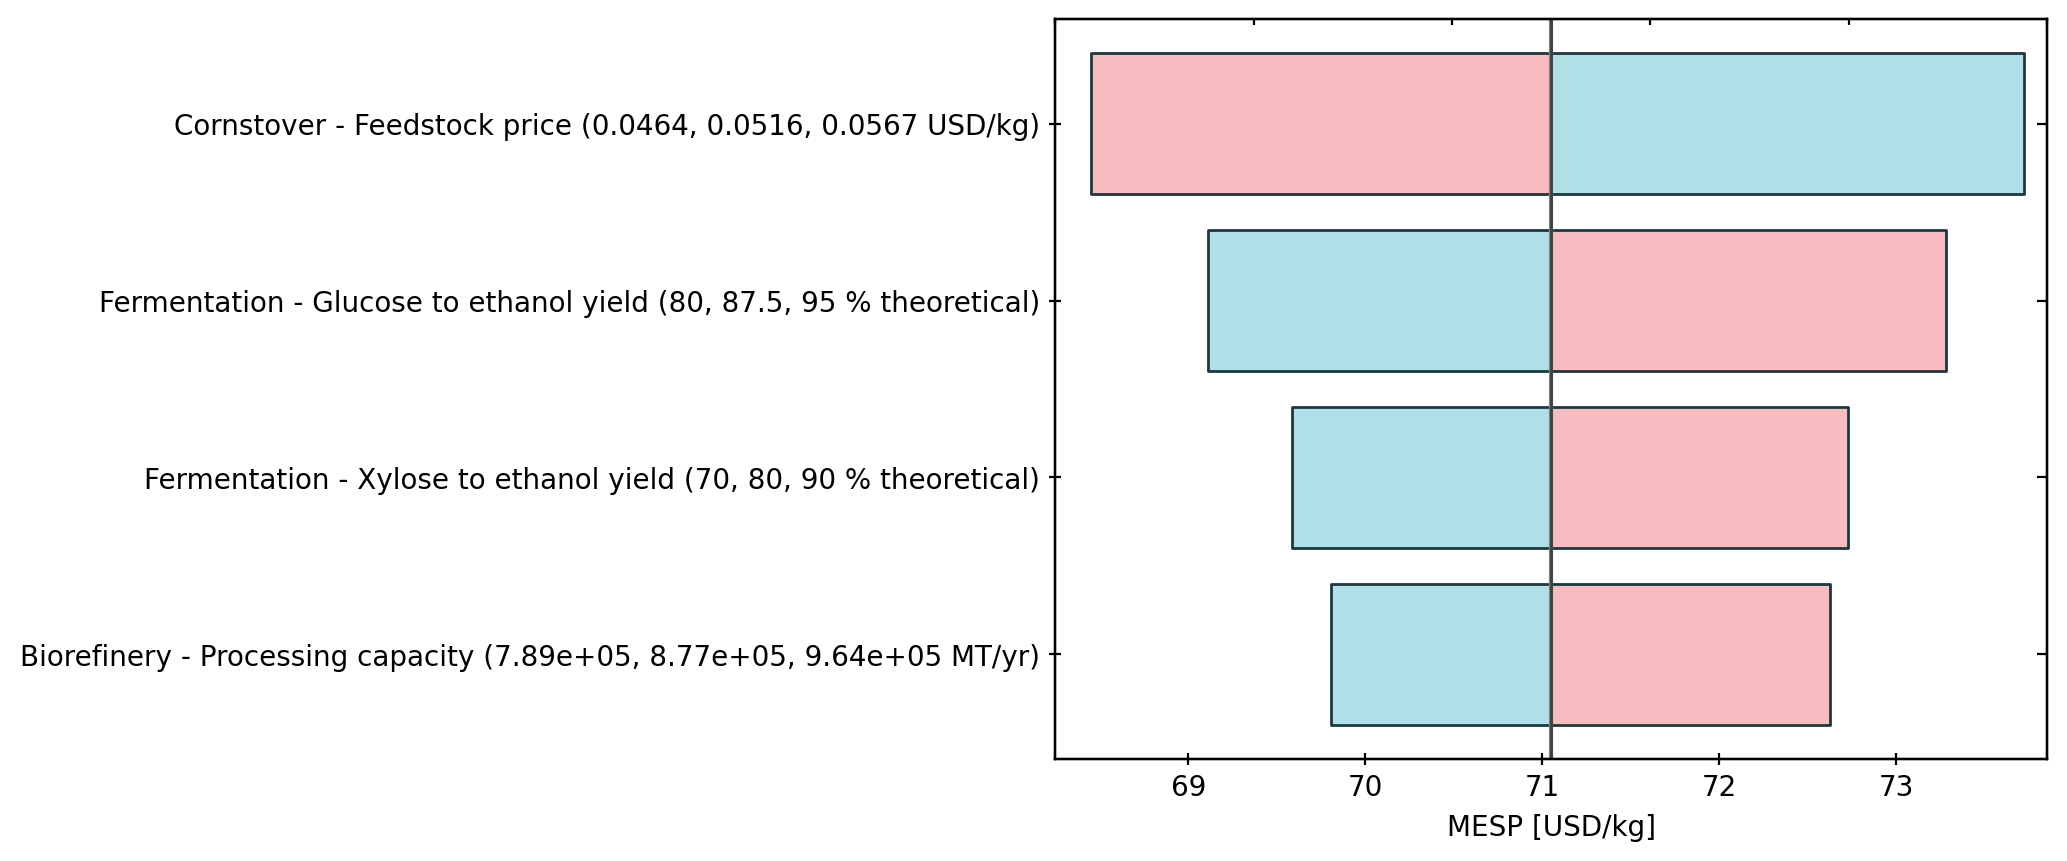

In [16]:
IRR, utility_cost = model.indicators
metric_index = IRR.index
index = [i.describe(distribution=False) # Instead of displaying distribution, it displays lower, baseline, and upper values
         for i in model.parameters] 
bst.plots.plot_single_point_sensitivity(100 * baseline[metric_index],
                                        100 * lower[metric_index], 
                                        100 * upper[metric_index],
                                        name='MESP [USD/kg]',
                                        index=index)

Note that blue represents the upper limit while red the lower limit.